In [1]:
from __future__ import absolute_import
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import itertools
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

from pyvis.network import Network
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt 
from pyscnet.Preprocessing import gnetdata
from pyscnet.BuildNet import gne_dockercaller as gdocker
from pyscnet.BuildNet import gne_synchrony as gs
from pyscnet.NetEnrich import graph_toolkit as gt

pd.set_option('display.max_rows', 1000)

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.17.5 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1


In [3]:
import stream as st
adata = st.read('data/stream_adata.pklz')

#Import stream anndata into pyscnet
stream_gne = gnetdata.load_from_scanpy(adata)

Working directory is already specified as './result' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


In [4]:
#select cells from S1 -> S2
cell_info = stream_gne.CellAttrs['CellInfo'].sort_values('S1_pseudotime', ascending=True)
cell = list(cell_info.loc[cell_info['branch_id_alias'].isin([('S2', 'S1')])].index)
len(cell)

535

As reported in [this publication](https://www.pnas.org/content/114/23/5822), GRNs specific for **MEP (S1->S2)** and **LMPP(S1->S3)** were built based on pre-selected 31 features. In the following, cells from above branches will be individually tested for gene correlation. 

In [7]:

feature = ['Bptf', 'Cbfa2t3', 'Erg', 'Ets1', 'Ets2', 'Etv6', 'Fli1', 'Gata1', 'Gata2', 'Gata3', 'Gfi1b', 'Hhex',
           'Hoxa5', 'Hoxa9', 'Hoxb4', 'Ikzf1', 'Ldb1', 'Lmo2', 'Lyl1', 'Meis1', 'Mitf', 'Myb', 'Nfe2', 'Nkx2-3',
           'Notch1', 'Pbx1', 'Prdm16', 'Runx1', 'Smarcc1', 'Tal1', 'Tcf7']

list(filter(lambda x:'Not' in x, stream_gne.ExpMatrix.index))
# [gene in stream_gne.ExpMatrix.index for gene in Features_Paper]

['Notumos', 'Notum', 'Noto', 'Notch4', 'Notch2', 'Notch3', 'Notch1']

In [8]:
#GRNs for MEP branch
stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='GENIE3', directed=False,
                               feature=feature, cell=cell)

stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='PIDC', directed=False,
                               feature=feature, cell=cell)

stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='CORR', directed=False,
                               feature=feature, cell=cell)

stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='GRNBOOST2', directed=False,
                               feature=feature, cell=cell)

stream_gne = gs.get_synchrony(stream_gne.deepcopy, method='window_rolling',
                               feature=feature, cell=cell)

stream_gne = gs.get_synchrony(stream_gne.deepcopy, method='phase_synchrony',
                               feature=feature, cell=cell)

GENIE3_links added into NetAttrs
PIDC_links added into NetAttrs
CORR_links added into NetAttrs
GRNBOOST2_links added into NetAttrs
window_rolling_links added into NetAttrs
phase_synchrony_links added into NetAttrs


In [21]:
Ref_edges = pd.read_csv('/home/mwu/MING_V9T/PhD_Pro/Test/Simulation/BoolODE_Data/BoolODE_Data_Repeat_Jun2020/HSC_MEP_2/refNetwork.csv', 
                          sep=',').iloc[:,:2]

Ref_edges.columns = ['source', 'target']
Ref_edges['weight'] = 1
Ref_edges.head()

,source,target,weight
0,Gata3,Gata3,1
1,Gata3,Myb,1
2,Ldb1,Smarcc1,1
3,Ldb1,Myb,1
4,Ldb1,Lmo2,1


In [37]:
Ref_edges = pd.read_csv('/home/mwu/Desktop/refNetwork.csv', 
                          sep=',').iloc[:,:2]

Ref_edges.columns = ['source', 'target']
Ref_edges['weight'] = 1
Ref_edges.shape

#remove self-loop edges
index_list=list()
for i in range(Ref_edges.shape[0]):
    if Ref_edges.iloc[i]['source'] == Ref_edges.iloc[i]['target']:
        index_list.append(i)
Ref_edges=Ref_edges.drop(index_list)

#As edges are undirected, the following is to create Full reference links (117*116/2) and then merge with the string links 
from itertools import product, permutations, combinations, combinations_with_replacement
Full_Ref = pd.DataFrame(combinations(set(feature), 2), columns=['source', 'target'])
Full_Ref['weight'] = 0

Ref_edges['name'] = Ref_edges['source'] + '_' + Ref_edges['target']
Full_Ref['name'] = Full_Ref['source']+ '_' + Full_Ref['target']

i = 0
for name in Ref_edges.name:
    tmp = list(name.split('_'))
    
    if name in list(Full_Ref['name']):
        
        
        Full_Ref.loc[Full_Ref.name ==  name, 'weight'] = 1
    
    elif tmp[1] + '_' + tmp[0] in list(Full_Ref['name']):
        
        
        Full_Ref.loc[Full_Ref.name == tmp[1] + '_' + tmp[0], 'weight'] = 1
    
    else:
        i = i +1
        
Full_Ref[Full_Ref.weight == 1].shape

(66, 4)

<!-- #extend reference links by shortest paths
import networkx as nx
Tmp = Full_Ref[Full_Ref.weight == 1]
G = nx.from_pandas_edgelist(Tmp)
path_len = list()
for i in range(Full_Ref.shape[0]):
    if Full_Ref.iloc[i]['source'] in G.nodes and Full_Ref.iloc[i]['target'] in G.nodes:
        if nx.has_path(G, Full_Ref.iloc[i]['source'], Full_Ref.iloc[i]['target']):
            path_len.append(nx.shortest_path_length(G, Full_Ref.iloc[i]['source'], Full_Ref.iloc[i]['target']))
        else:
            path_len.append(0)
    else:
        path_len.append(0)
    

Full_Ref['path_len'] = path_len
Full_Ref['weight'] = [1 if x in [1,2] else 0 for x in Full_Ref.path_len]
Full_Ref[Full_Ref.weight == 1].shape -->

In [12]:
#map edges and calculate roc score
from sklearn import metrics

def mapping_edges(df_1, df_2, df_1_col_1, df_1_col_2, df_2_col_1, df_2_col_2):
    
    df_1['tmp1'] = df_1[df_1_col_1] + '_' + df_1[df_1_col_2]
    df_2['tmp1'] = df_2[df_2_col_1] + '_' + df_2[df_2_col_2]
    
    df_2['tmp2'] = df_2[df_2_col_2] + '_' + df_2[df_2_col_1]

    return len(set(df_1['tmp1']) & set(df_2['tmp1'])) + len(set(df_1['tmp1']) & set(df_2['tmp2']))


def evaluation(links, Full_Ref):
        
    Detected = links.shape[0]
    Ref_links = Full_Ref[Full_Ref.weight == 1]
    TP = mapping_edges(links, Ref_links, 'source', 'target', 'source', 'target')
    FN = Ref_links.shape[0] - TP
    FP = Detected - TP
    TN = Full_Ref.shape[0] - Ref_links.shape[0] - Detected + TP

    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    FDR = FP / (TN + FP)
    F1_Score = (2 * Precision * Recall) / (Precision + Recall)
    
    print('TP:', TP, '\n', 'FN:', FN, '\n', 'FP:', FP, '\n', 'TN:', TN)
    
    links['name'] = links['source'] + '_' + links['target']
    
    for name in links.name:
        tmp = list(name.split('_'))
        if name in list(Full_Ref['name']):
            Full_Ref.loc[Full_Ref.name ==  name, 'weight_2'] = float(format(float(links.loc[links.name == name, 'weight']), '.2f'))
        
        elif tmp[1] + '_' + tmp[0] in list(Full_Ref['name']):
            Full_Ref.loc[Full_Ref.name == tmp[1] + '_' + tmp[0], 'weight_2'] = float(format(float(links.loc[links.name == name, 'weight']), '.2f'))
    
        else: continue
            
    Full_Ref = Full_Ref.fillna(0)
    auc = metrics.roc_auc_score(np.array(Full_Ref['weight'].abs()), np.array(Full_Ref['weight_2'].abs()))
    fpr, tpr, threshold_1 = metrics.roc_curve(Full_Ref['weight'].abs(), Full_Ref['weight_2'].abs())
    pre, recall, threshold_2 = metrics.precision_recall_curve(Full_Ref['weight'].abs(),
                                                              Full_Ref['weight_2'].abs())
    
    avg_pre_auc = metrics.auc(recall, pre)
    
    return {'fpr' :fpr, 'tpr' :tpr, 'pre': pre, 'recall': recall, 'auc':auc, 
            'avg_pre': avg_pre_auc, 'Precision': Precision, 'Recall' : Recall, 'F1_Score' : F1_Score}


import seaborn as sns
def build_curves(ax, dict_of_algs,curve, filename, colors=None, **kwarg):
    
    names = dict_of_algs.keys()
    
    keywords = ['fpr', 'tpr'] if curve == 'ROC' else ['recall', 'pre']
    fill = 1 if curve == 'ROC' else 0

    colors = sns.color_palette().as_hex() + sns.color_palette('hls', 8).as_hex() if colors is None else colors
    section_dict = {sec : {} for sec in ['fpr_dict', 'tpr_dict', 'auc_dict', 'avgpre_dict']}
    
    for name in names:
        section_dict['fpr_dict'][name] = dict_of_algs[name][keywords[0]]
        section_dict['tpr_dict'][name] = dict_of_algs[name][keywords[1]]
        section_dict['auc_dict'][name] = dict_of_algs[name]['auc']
        section_dict['avgpre_dict'][name] = dict_of_algs[name]['avg_pre']
        
    for i, color in zip(list(section_dict['auc_dict'].keys()), colors):
        ax.plot(section_dict['fpr_dict'][i], section_dict['tpr_dict'][i],
                label='ROC curve {0} (area = {1:0.2f})'.format(i, section_dict['auc_dict'][i]) if curve == 'ROC' else
                'PR curve {0} (area = {1:0.2f})'.format(i, section_dict['avgpre_dict'][i]),
                color=color, **kwarg)
   
    if curve == 'ROC':
        ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate' if curve == 'ROC' else 'Recall', fontsize=20)
    ax.set_ylabel('True Positive Rate' if curve == 'ROC' else 'Precision', fontsize=20)
    ax.legend(loc="lower right")

In [38]:
dict_of_algs = dict()
link_keys = list(filter(lambda x:'_links' in x, stream_gne.NetAttrs.keys()))

for link in link_keys:
    method = link.split('_links')[0]
    top = stream_gne.NetAttrs[link].sort_values('weight', ascending=False).head(66)
    dict_of_algs[method] = evaluation(top, copy.deepcopy(Full_Ref))

TP: 16 
 FN: 50 
 FP: 50 
 TN: 349
TP: 12 
 FN: 54 
 FP: 54 
 TN: 345
TP: 15 
 FN: 51 
 FP: 51 
 TN: 348
TP: 16 
 FN: 50 
 FP: 50 
 TN: 349
TP: 12 
 FN: 54 
 FP: 54 
 TN: 345
TP: 16 
 FN: 50 
 FP: 50 
 TN: 349


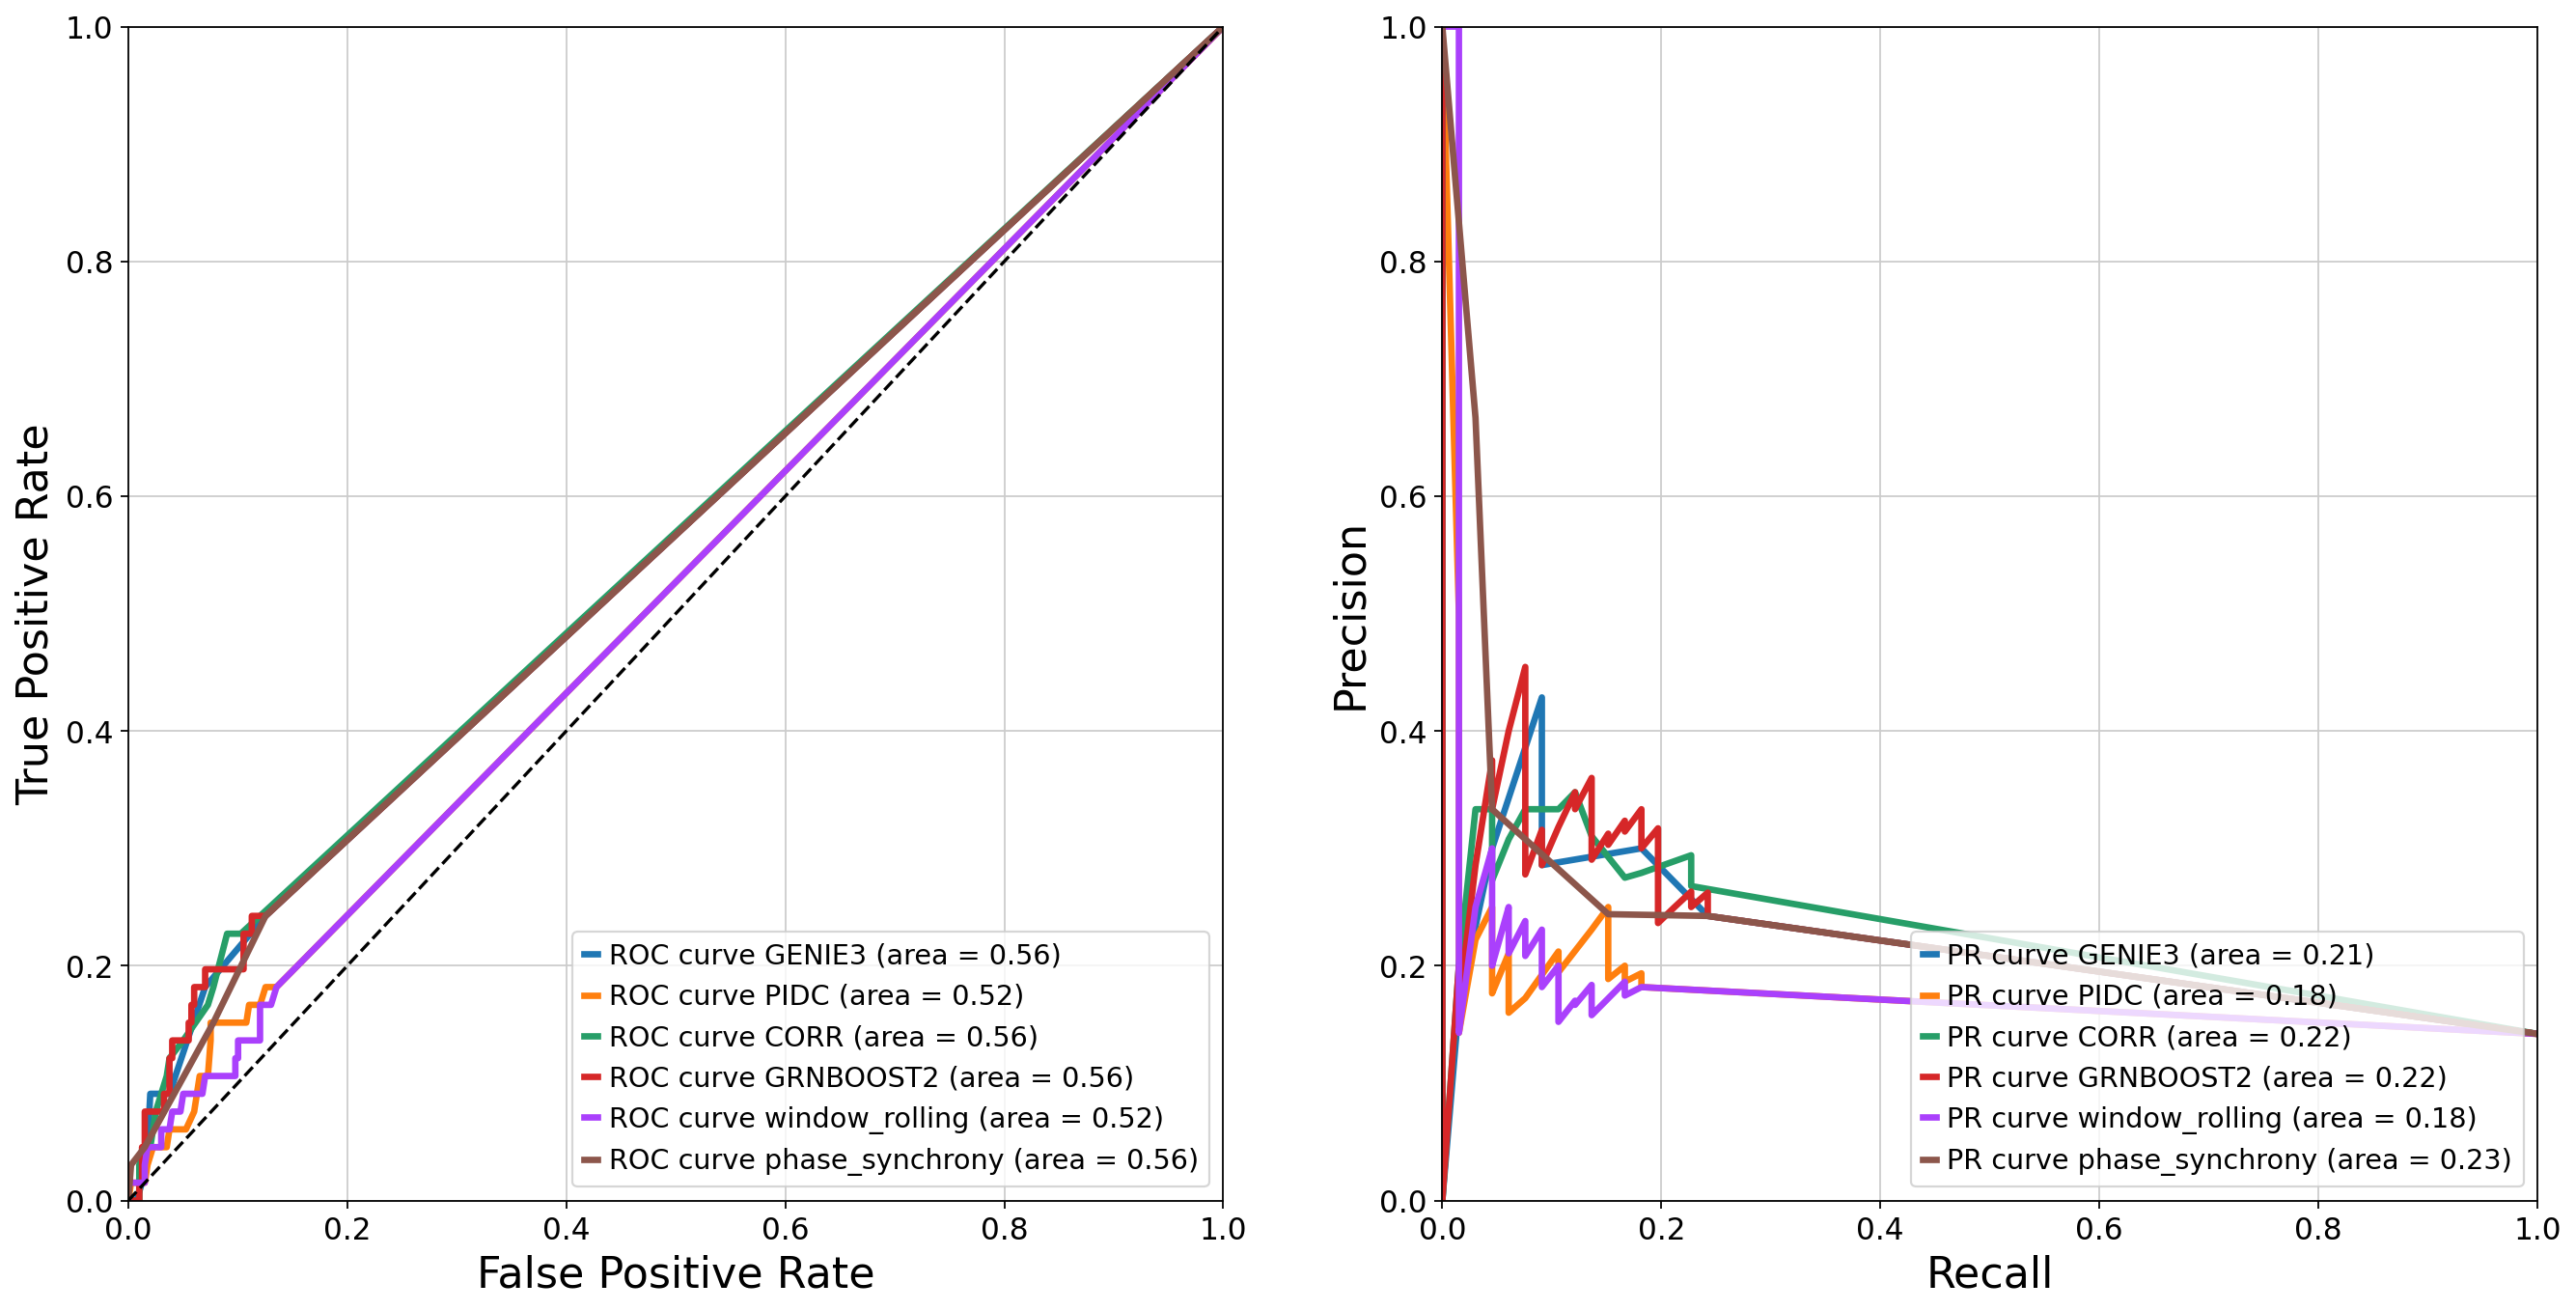

In [39]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])

filename='test'
build_curves(ax1, dict_of_algs, 'ROC', filename, linewidth=3)
build_curves(ax2, dict_of_algs, 'PCR', filename, linewidth=3)

In [69]:
#build graph
from pyscnet.NetEnrich import graph_toolkit as gt
stream_gne = gt.buildnet(stream_gne, key_links='phase_synchrony_links', top=66)

#calculate node centrality
stream_gne = gt.get_centrality(stream_gne)

#detect gene community
stream_gne = gt.detect_community(stream_gne, resolution=0.8)

graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs


In [47]:
# #Supervised random walk
random_path = gt.random_walk(stream_gne, start = 'Gata1', supervisedby='degree', steps=5)
random_path

['Gata1', 'Lyl1', 'Cbfa2t3', 'Gata2', 'Erg', 'Prdm16']

In [42]:
Ref_edges.loc[(Ref_edges.target=='Gata1') | (Ref_edges.source == 'Gata1')]

,source,target,weight,name
12,Cbfa2t3,Gata1,1,Cbfa2t3_Gata1
19,Gata2,Gata1,1,Gata2_Gata1
22,Gfi1b,Gata1,1,Gfi1b_Gata1
48,Myb,Gata1,1,Myb_Gata1
62,Nkx2-3,Gata1,1,Nkx2-3_Gata1
79,Smarcc1,Gata1,1,Smarcc1_Gata1
81,Tal1,Gata1,1,Tal1_Gata1
91,Tcf7,Gata1,1,Tcf7_Gata1


In [53]:
tmp = stream_gne.NetAttrs['phase_synchrony_links'].sort_values('weight', ascending=False).head(66)
tmp.loc[(tmp.target=='Gata1') | (tmp.source == 'Gata1')]


,source,target,weight
88,Gfi1b,Gata1,0.792523
163,Gata1,Lyl1,0.783178
157,Gata1,Bptf,0.777570


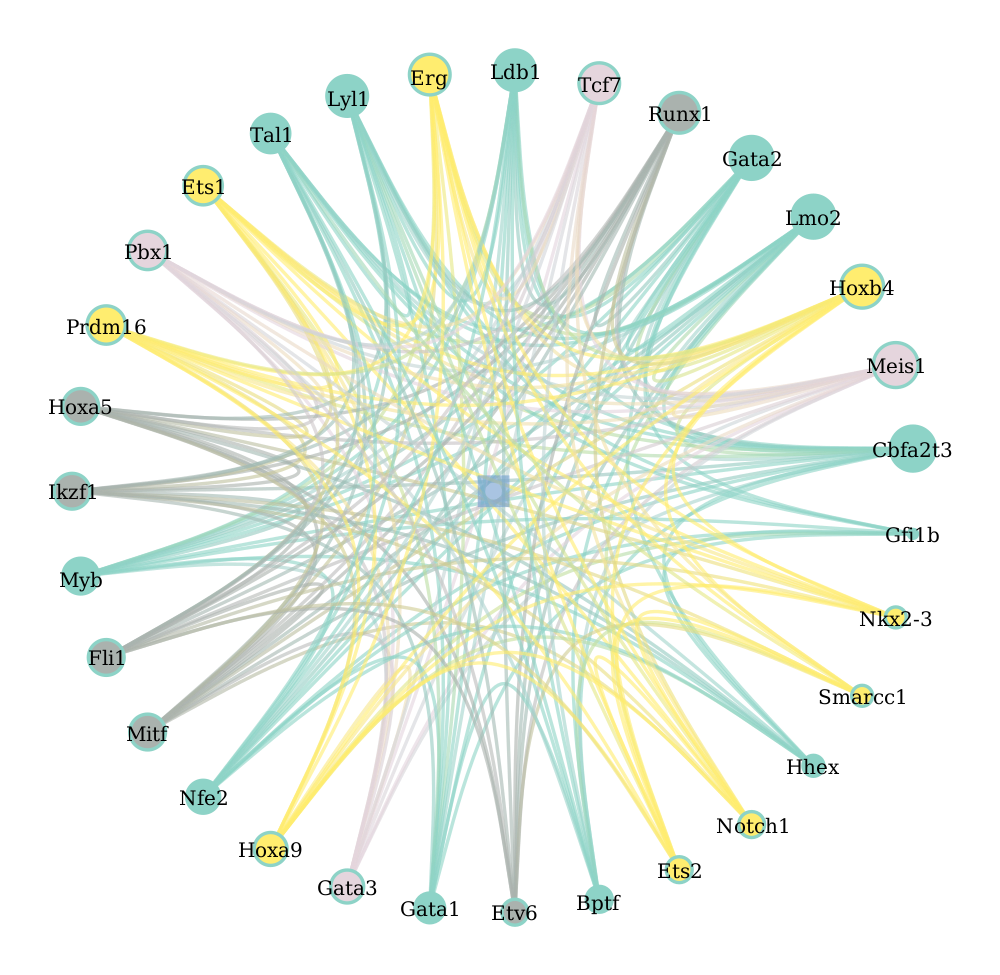

In [67]:
from pyscnet.Plotting import net_plot as npl

npl.net_hierarchy_plot(stream_gne, output_size=(500, 500), vertex_text_position=-2, 
                       vertex_font_size=10)

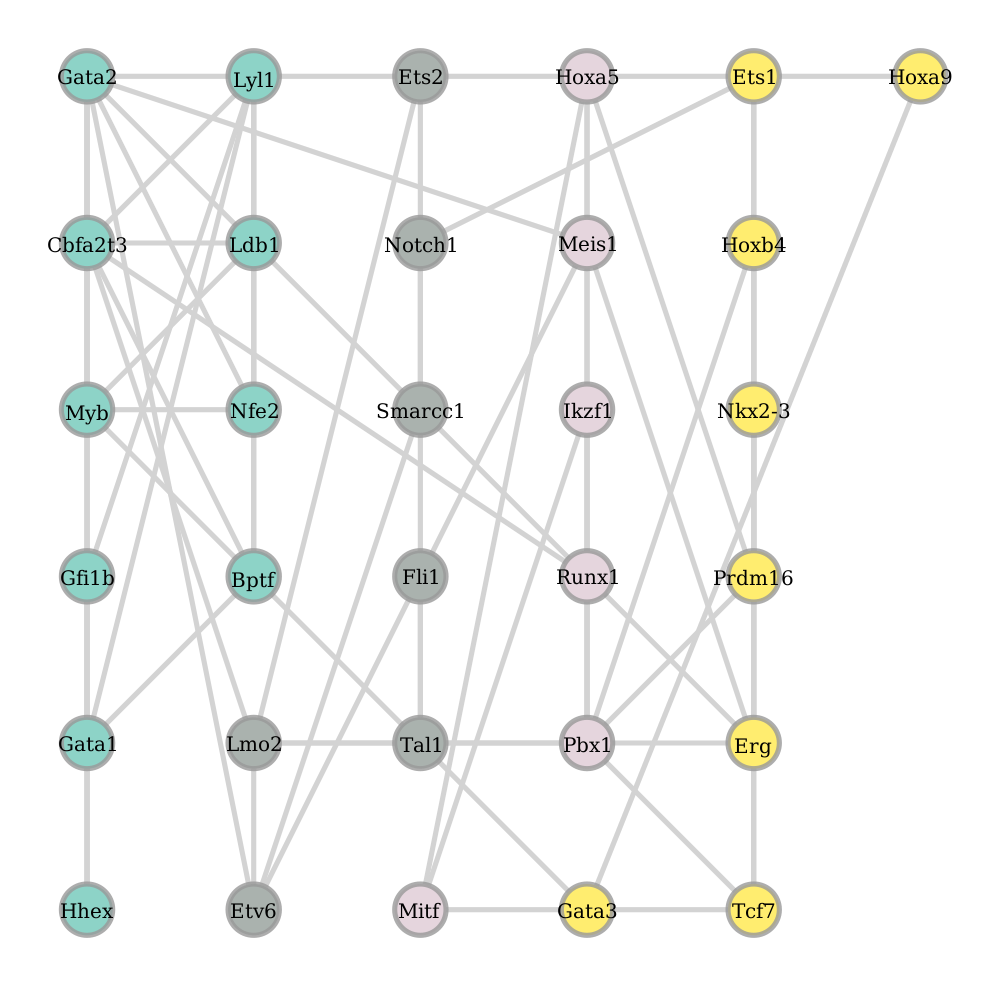

In [70]:
npl.net_matrix_plot(stream_gne, output_size=(500, 500),
                   vertex_text_position=-2, vertex_font_size=10)